# Feedback

## Load Modules

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ",file_dir)

parent_dir = file_dir.parent
print(parent_dir)

sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [122]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    clean_up_categoricals
    )

from pa_lib.vis import (
    boxplot_histogram,
    )

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    )                 
import os,fnmatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://stackabuse.com/python-list-files-in-a-directory/

# Load Data (Feedback)

In [294]:
def load_feedback(sales_folder):
    sales_subfolder = os.listdir(sales_folder)
    pattern = "EK_LIST*.xlsx"
    
    container_df = pd.DataFrame()
    columns_in_xlsx = ["Gepard-Nr. Endkunde","Endkunde", "Chance","Feedback - bitte auswählen", "falls nicht hilfreich, bitte hier einen kurzen Kommentar angeben - entweder pro Zeile oder für die Gesamt-Liste" ]
    rename_columns = ["Endkunde_NR", "Endkunde", "Prob_1","Feedback", "Kommentar"]

    
    for kw_folder in sales_subfolder:

        if kw_folder >= "2019_07_15": # Begin of automatisation

            all_files_list = os.listdir(sales_folder / kw_folder)

            for file in all_files_list:

                if fnmatch.fnmatch(file, pattern):
                    #print(f"{kw_folder}  ---- {file}") # Check!
                    vkber_df = (
                        load_xlsx(
                            sales_folder / kw_folder / file
                            )
                        .loc[:,columns_in_xlsx]
                        )#.iloc[:,[0,1,-3,-2,-1]])
                    
                    vkber_df.columns = rename_columns

                    vkber_df.loc[:,"folder"] = kw_folder
                    vkber_df.loc[:,"file_name"] = file

                    container_df = (
                        container_df.append(vkber_df,ignore_index=False)
                        )
    
    container_df.loc[:,"Kuerzel"] = container_df.loc[:,"file_name"].apply(lambda x: x[19:22])
    
    #Remove all redundant rows:
    feedback_exists = (
        (   # Feedback or Kommentar exists
            ~container_df.loc[:, "Feedback"].isna() |
            ~container_df.loc[:,"Kommentar"].isna()
            ) & # Endkunde_NR must exist
            ~container_df.loc[:,"Endkunde_NR"].isna()
        )
    
    
    
    return container_df.loc[feedback_exists,:].sort_values(["folder","file_name"], ascending=[False,True])

In [295]:
sales_folder = Path('P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics')
print(sales_folder)

P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics


In [296]:
raw_feedback = load_feedback(sales_folder=sales_folder)

16:25:22 [INFO] Started loading xlsx file ...
16:25:22 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_15\EK_LIST_2W_KOMPAKT_ABS.xlsx
16:25:22 [INFO] ... finished loading xlsx file in 0.07s (0.0s CPU)
16:25:22 [INFO] Started loading xlsx file ...
16:25:22 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_15\EK_LIST_2W_KOMPAKT_ACO.xlsx
16:25:22 [INFO] ... finished loading xlsx file in 0.05s (0.02s CPU)
16:25:22 [INFO] Started loading xlsx file ...
16:25:22 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_15\EK_LIST_2W_KOMPAKT_BAM.xlsx
16:25:22 [INFO] ... finished loading xlsx file in 0.04s (0.02s CPU)
16:25:22 [INFO] Started loading xlsx file ...
16:25:22 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_15\EK_LIST_2W_KOMPAKT_BEG.xlsx
16:25:22 [INFO] ... finished loading xlsx file in 0.04s (0.02s CP

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


16:25:24 [INFO] ... finished loading xlsx file in 0.06s (0.0s CPU)
16:25:24 [INFO] Started loading xlsx file ...
16:25:24 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29\EK_LIST_2W_KOMPAKT_ACO.xlsx
16:25:24 [INFO] ... finished loading xlsx file in 0.07s (0.02s CPU)
16:25:24 [INFO] Started loading xlsx file ...
16:25:24 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29\EK_LIST_2W_KOMPAKT_BAM.xlsx
16:25:24 [INFO] ... finished loading xlsx file in 0.05s (0.02s CPU)
16:25:24 [INFO] Started loading xlsx file ...
16:25:24 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29\EK_LIST_2W_KOMPAKT_BEG.xlsx
16:25:24 [INFO] ... finished loading xlsx file in 0.06s (0.02s CPU)
16:25:24 [INFO] Started loading xlsx file ...
16:25:24 [INFO] Reading from file \\fppwi01\daten$\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29\EK_LIST_2W_KOMPAKT_BON.xl

# Feedback Count

In [297]:
print(f"shape: {raw_feedback.shape}")

shape: (742, 8)


In [298]:
min(raw_feedback.shape[0], 3000)

742

In [299]:
import pandas as pd
pd.set_option('display.max_rows', min(raw_feedback.shape[0]+1 ,3000))
pd.set_option("display.max_colwidth",500)

In [300]:
raw_feedback.sample(5)

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name,Kuerzel
0,544088,FREPP- Fédération suisse romande,39.457577,nicht hilfreich,ce client a fait des campagnes par le bureau des métiers en 2019,2019_11_18,EK_LIST_2W_KOMPAKT_PIE.xlsx,PIE
16,113679,Hotel Suvretta House,34.108619,hilfreich,Buchungen sind bereits erfolgt,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx,BON
15,538159,Carpoint SA,2.400000,hilfreich,NaN,2019_09_23,EK_LIST_2W_KOMPAKT_LPA.xlsx,LPA
12,149469,Claudio Caviezel GmbH,2.300000,hilfreich,TMS Bernmobil Aktion 50%,2019_11_04,EK_LIST_2W_KOMPAKT_CFU.xlsx,CFU
5,586270,Stiftung Frauenhaus Graubünden,6.500000,nicht hilfreich,Einmalige Kampagne zum Frauentag,2019_11_04,EK_LIST_2W_KOMPAKT_BON.xlsx,BON


# Participation?

In [211]:
(
raw_feedback
    .groupby("folder")
    .agg({"Endkunde_NR": "count"})
    
)

,Endkunde_NR
folder,
2019_07_15,106
2019_09_23,111
2019_10_07,120
2019_10_21,106
2019_11_04,141
2019_11_18,158


Text(0.5, 1.0, 'Total: Teilnahme')

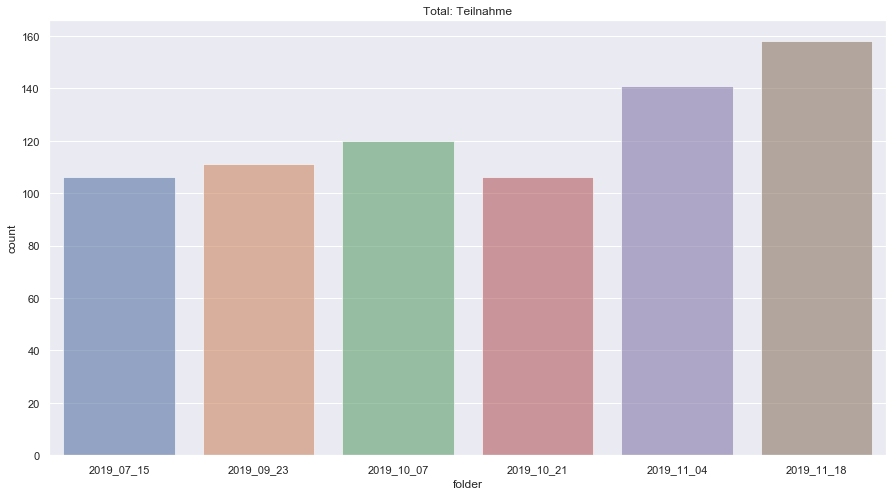

In [346]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "folder",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        #order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )
    
plt.title("Total: Teilnahme")

***
> 1. Participation is increasing
2. The Vkber-Lists in the following folders have not been touched (see also timestamps on each xlsx-file):
    * `2019_09_09`
    * `2019_08_26` 
    * `2019_08_12`
    * [`2019_07_29`](P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29)
***

## Top participants

In [306]:
(
raw_feedback
    .groupby("Kuerzel")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
).T

Kuerzel,LPA,BON,TRA,JAN,CGA,ACO,ROK,MBU,MZB,PIE,...,PAL,CFU,ROE,SOL,REM,RON,MOE,RPO,RIN,MTO
Endkunde,116,100,61,59,49,39,30,27,25,24,...,21,20,20,20,20,17,15,8,6,1


Text(0.5, 1.0, 'Total: Anzahl Feedbacks pro Gruppe')

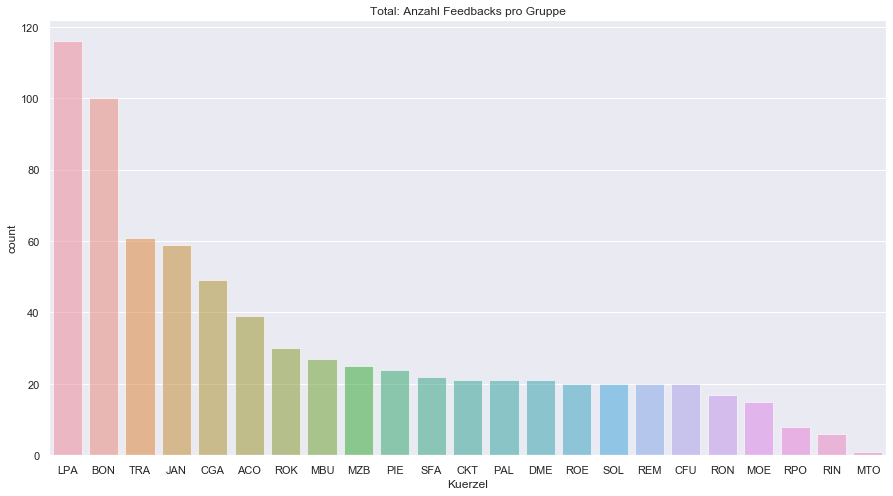

In [305]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "Kuerzel",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")

(23.0, 0.0)

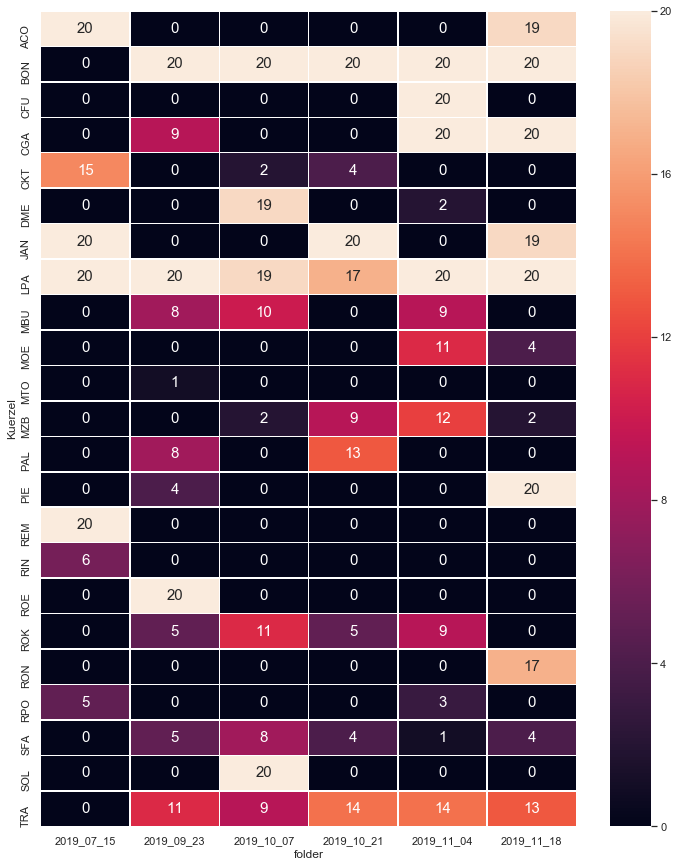

In [302]:
heatmap_data = pd.pivot_table(
    raw_feedback,
    index      = "folder",
    columns    = "Kuerzel",
    values     = "Endkunde_NR",
    aggfunc    = np.count_nonzero,
    fill_value = 0
    ).T

plt.figure(figsize=(12,15))

ax = sns.heatmap(
    data       = heatmap_data,
    linewidths = 0.5,
    annot      = True,
    annot_kws={"size": 15},
    )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

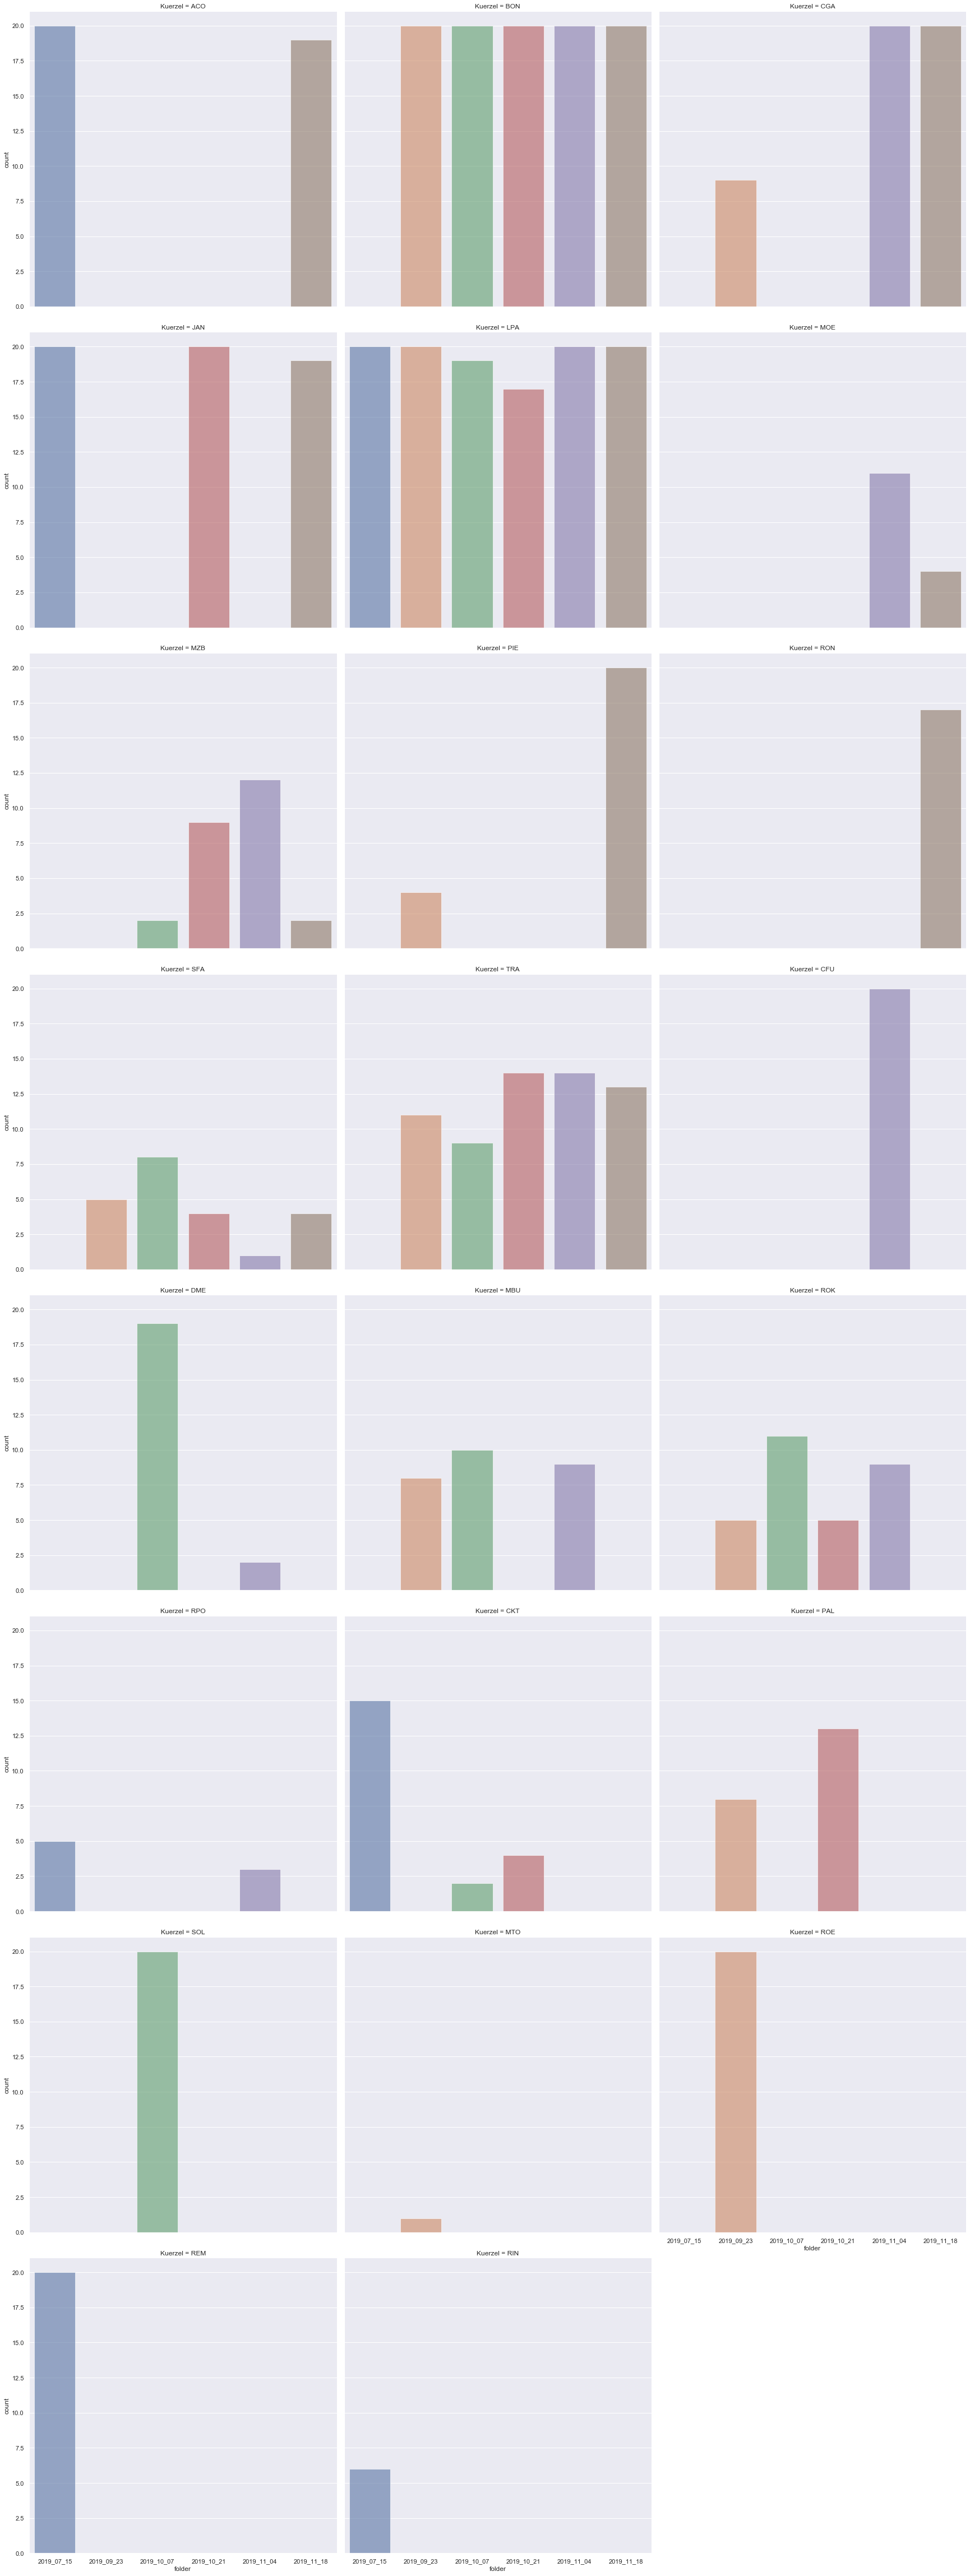

In [341]:
g = (
    sns.catplot(
        x="folder",
        #hue="folder",
        col="Kuerzel",
        data=raw_feedback,
        kind="count",
        height=8,
        aspect=1,
        col_wrap=3,
        alpha=0.6,
        )
    )     

***
> It's not fair to discriminate those, who don't participate. 
Not everybody receives the same amount of leads
***

# Feedback so far: helpful? not helpful?

In [201]:
(
raw_feedback
    .groupby("Feedback")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
)

,Endkunde
Feedback,
hilfreich,273
nicht hilfreich,253
nicht bearbeitet,42


Text(0.5, 1.0, 'Total: Anzahl Feedbacks pro Gruppe')

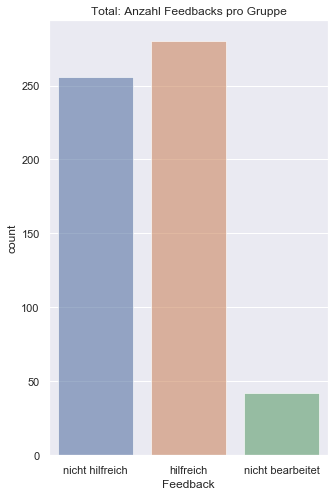

In [343]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,8))
ax = (
    sns.countplot(
        x     = "Feedback",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")

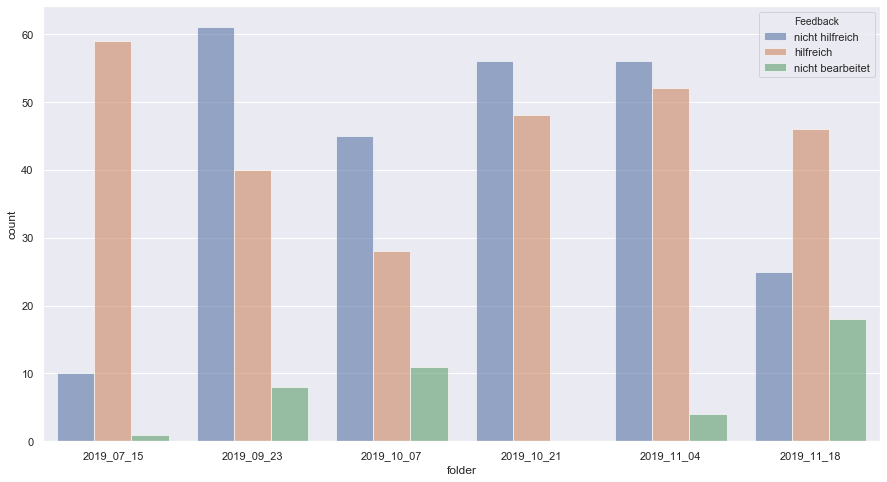

In [269]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "folder",
        hue   = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )

***
> `hilfreich` and `nicht hilfreich` holding their balance
***

# Looking into `Kommentar`

## The bad ones: `nicht hilfreich`, `nicht bearbeitet`, `NaN`

In [253]:
not_helpful_rows = (
    ~raw_feedback
        .Feedback
        .isin({"hilfreich"}))

raw_feedback.loc[not_helpful_rows,:]

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name
0,469781,CSL Immobilien AG,58.316522,NaN,Kunde ist in Zürich - Plakate sind abhängig von Objekten,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
1,519262,Hobi Moto AG,51.759579,NaN,via Ace 2 ACe,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
2,638475,Autoneum Management AG,51.302511,NaN,Autosalon Genf - Via MAT,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
3,515580,Verein Winterthurer Musikfestwochen,47.155711,NaN,"bin dran, gibt ein Sponsoring 2020",2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
4,139367,WEGA Messe AG,36.004276,NaN,Agentur wurde aufgelöst,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
6,637276,Grünliberale Partei Kanton Zürich,34.426872,NaN,Wahlen 2019,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
7,537586,VIVA für Frauen,31.002352,NaN,buchen nur F4 - Winterthur -neu bei NEO,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
8,471431,Gianni's Pizzakurier,29.506658,NaN,buchen nur F4 - Winterthur -neu bei NEO,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
9,544744,inhaus Messe GmbH,29.473159,NaN,Agentur wurde aufgelöst,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx
10,596555,Verein Hutzenlaub & Stäubli,29.241164,NaN,einmaliges Sponsoring,2019_11_18,EK_LIST_2W_KOMPAKT_ACO.xlsx


***
> 1. In den einzelnen Listen befinden sind politische Gruppierungen vorhanden. Nicht erwünscht.
2. Einige der Endkunden sind aufgelöst (zb. Insolvenz)
3. Einige Kunden buchen ausschliesslich über Agentur
4. Kunden sind eigentlich bei anderem Verkausberater
5. Einige Kunden haben für einmalige Events bei uns in der Vergangenheit gebucht. Keine Wiederholungen geplant (zb. Jubiläen)
***

## The Good Ones: `hilfreich`

In [254]:
helpful_rows = ~not_helpful_rows

In [255]:
raw_feedback.loc[helpful_rows,:]

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name
1,640149,Schweizerische Mobiliar,52.455315,hilfreich,Sofort kontakt aufgenommen mit herr schmutz,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
2,642120,Imperial Lounge Club GmbH,45.013510,hilfreich,Mail an Hito gemacht für 2020,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
3,124916,Hotel Waldhaus,42.424343,hilfreich,"Kontakt mit Kde, noch offen ob etwas kommt",2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
7,582188,ONAX AG it solutions,39.726583,hilfreich,Aktion nochmals geschickt,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
11,606382,Pur.Catering GmbH,37.057535,hilfreich,"Stehen im Kontakt mit Agentur, Budget steht noch nicht",2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
13,570719,BIKE EXPLORER,35.347227,hilfreich,"Aktion Thema, stehen im kontakt mit agentur",2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
14,510724,Open Air Lumnezia AG,34.470454,hilfreich,"Stehen im Kontakt mit Agentur, Budget steht noch nicht",2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
15,620421,oohh! fine fashion GmbH,34.209751,hilfreich,Aktion nochmals geschickt,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
16,113679,Hotel Suvretta House,34.108619,hilfreich,Buchungen sind bereits erfolgt,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx
17,570636,Velocenter Imholz AG,33.417290,hilfreich,Aktion nochmals geschickt,2019_11_18,EK_LIST_2W_KOMPAKT_BON.xlsx


***
> 1. Inkonsistente Beurteilung der Leeds. Obwohl vermerkt, dass Kunde kein Interesse hat, wird der Lead als `hilfreich` bewertet.
***

In [256]:
titanic = sns.load_dataset("titanic")

In [257]:
titanic.sample(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
111,0,3,female,14.5,1,0,14.4542,C,Third,child,False,NaN,Cherbourg,no,False
291,1,1,female,19.0,1,0,91.0792,C,First,woman,False,B,Cherbourg,yes,False
196,0,3,male,NaN,0,0,7.7500,Q,Third,man,True,NaN,Queenstown,no,True
633,0,1,male,NaN,0,0,0.0000,S,First,man,True,NaN,Southampton,no,True
670,1,2,female,40.0,1,1,39.0000,S,Second,woman,False,NaN,Southampton,yes,False
679,1,1,male,36.0,0,1,512.3292,C,First,man,True,B,Cherbourg,yes,False
867,0,1,male,31.0,0,0,50.4958,S,First,man,True,A,Southampton,no,True
503,0,3,female,37.0,0,0,9.5875,S,Third,woman,False,NaN,Southampton,no,True
301,1,3,male,NaN,2,0,23.2500,Q,Third,man,True,NaN,Queenstown,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True


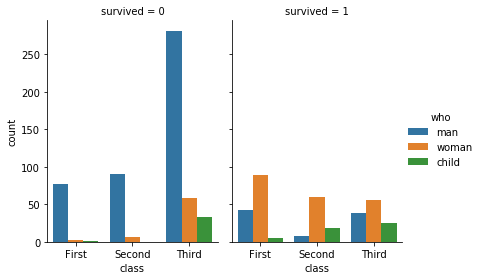

In [260]:
g = (
    sns.catplot(
        x="class",
        hue="who",
        col="survived",
        data=titanic,
        kind="count",
        height=4,
        aspect=.7,
        )
    )     